In [25]:
# Cell 1 — Environment setup for CricVision v2

import os, sys, tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# GPU check
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU detected:", gpus[0])
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except Exception as e:
        print("Could not set memory growth:", e)
else:
    print("No GPU detected — training will fall back to CPU.")

# Paths
SHOT_MODEL_PATH = "/content/drive/MyDrive/CricVision/shot_classification/shot_classifier.keras"
FORM_MODEL_PATH = "/content/drive/MyDrive/CricVision/cnn_bilstm_binary_classifier.keras"
MULTITASK_SAVE_PATH = "/content/drive/MyDrive/CricVision/cricvision_v2_multitask.keras"

print("\nLoaded paths:")
print("Shot model:", os.path.exists(SHOT_MODEL_PATH))
print("Form-quality model:", os.path.exists(FORM_MODEL_PATH))


GPU detected: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

Loaded paths:
Shot model: True
Form-quality model: True


In [26]:
# Cell 2 (fixed) — Extract EfficientNet backbone safely

# Load the trained shot classifier
shot_model = keras.models.load_model(SHOT_MODEL_PATH)
print("Shot classifier loaded successfully.\n")

# Display layer names and shapes safely
for i, layer in enumerate(shot_model.layers):
    shape = getattr(layer, "output_shape", "N/A")
    print(f"{i:02d} | {layer.name:<30} | Output: {shape}")

# Extract everything up to the dropout layer (shared features)
backbone_output_layer = "dropout_1"  # based on your layer name
backbone = keras.Model(
    inputs=shot_model.input,
    outputs=shot_model.get_layer(backbone_output_layer).output,
    name="shared_backbone"
)

# Freeze the backbone to retain shot classification knowledge
for layer in backbone.layers:
    layer.trainable = False

print("\nBackbone extracted and frozen.")
print("Backbone output shape:", backbone.output_shape)


Shot classifier loaded successfully.

00 | input_layer_4                  | Output: N/A
01 | efficientnetb0                 | Output: (None, 1280)
02 | dropout_1                      | Output: N/A
03 | dense_1                        | Output: N/A

Backbone extracted and frozen.
Backbone output shape: (None, 1280)


In [27]:
# Cell 3 — Build multi-task architecture

from tensorflow.keras import layers, Model

# Input: sequence of 8 frames, each 224x224x3
SEQ_LEN = 8
IMG_SIZE = (224, 224, 3)

# Define the input
sequence_input = layers.Input(shape=(SEQ_LEN, *IMG_SIZE), name="frame_sequence")

# Extract features for each frame using the frozen EfficientNet backbone
# Use TimeDistributed to apply the same backbone to every frame
x = layers.TimeDistributed(backbone, name="time_distributed_backbone")(sequence_input)

# BiLSTM to capture motion and temporal relationships
x = layers.Bidirectional(layers.LSTM(256, return_sequences=False, dropout=0.3), name="bilstm")(x)

# Shared dense layer before heads
shared_dense = layers.Dense(256, activation="relu", name="shared_dense")(x)
shared_dense = layers.Dropout(0.3)(shared_dense)

# Head 1: Shot type (4 classes)
shot_output = layers.Dense(4, activation="softmax", name="shot_type")(shared_dense)

# Head 2: Form quality (binary classification)
form_output = layers.Dense(1, activation="sigmoid", name="form_quality")(shared_dense)

# Build multi-task model
multitask_model = Model(inputs=sequence_input, outputs=[shot_output, form_output], name="cricvision_v2_multitask")

# Compile with weighted losses
losses = {
    "shot_type": "categorical_crossentropy",
    "form_quality": "binary_crossentropy"
}
loss_weights = {"shot_type": 0.7, "form_quality": 0.3}

multitask_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss=losses,
    loss_weights=loss_weights,
    metrics={"shot_type": "accuracy", "form_quality": "accuracy"}
)

multitask_model.summary()


Model: "cricvision_v2_multitask"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ frame_sequence      │ (None, 8, 224,    │          0 │ -                 │
│ (InputLayer)        │ 224, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_b… │ (None, 8, 1280)   │  4,049,571 │ frame_sequence[0… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bilstm              │ (None, 512)       │  3,147,776 │ time_distributed… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_dense        │ (None, 256)       │    131,328 │ bilstm[0][0]      │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 256)       │          0 │ shared_dense[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shot_type (Dense)   │ (None, 4)         │      1,028 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ form_quality        │ (None, 1)         │        257 │ dropout_3[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,329,960 (27.96 MB)

 Trainable params: 3,280,389 (12.51 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [28]:
# Cell 4 — Build sequence dataloader for multi-task training

import cv2
import numpy as np
import tensorflow as tf

# Paths (adjust if your form dataset is elsewhere)
FORM_DATASET_PATH = "/content/drive/MyDrive/CricVision/FormQuality_Videos"

# Helper function to read video and extract 8 frames
def load_video_frames(video_path, seq_len=8, target_size=(224, 224)):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_indices = np.linspace(0, total_frames - 1, seq_len, dtype=int)
    frames = []

    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if not ret:
            continue
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame, target_size)
        frame = frame.astype("float32") / 255.0
        frames.append(frame)

    cap.release()
    # Pad if frames are missing
    while len(frames) < seq_len:
        frames.append(np.zeros_like(frames[0]))
    return np.stack(frames, axis=0)

In [29]:
!unzip -q /content/all_frames_dataset.zip -d /content/all_frames_dataset.zip


checkdir:  cannot create extraction directory: /content/all_frames_dataset.zip
           File exists


In [30]:
!mkdir -p /content/all_frames_dataset
!unzip -q /content/all_frames_dataset.zip -d /content/all_frames_dataset


In [31]:
# Cell 5 — Build form-quality dataset (using local /content/all_frames_dataset path)

import os
import cv2
import numpy as np
from tqdm import tqdm

# Local dataset path (unzipped folder)
RAW_PATH = "/content/all_frames_dataset"

SEQ_LEN = 8
IMG_SIZE = (224, 224)
form_data = []
labels = []

def read_form_label(txt_path, threshold=6.0):
    """Compute binary label from action_scores.txt"""
    with open(txt_path, "r") as f:
        scores = [float(x) for x in f.read().strip().split()]
    if not scores:
        return None
    mean_score = np.mean(scores)
    return 1 if mean_score >= threshold else 0  # 1 = High, 0 = Not High

# Traverse all folders and process sequences
for folder in tqdm(sorted(os.listdir(RAW_PATH))):
    folder_path = os.path.join(RAW_PATH, folder)
    if not os.path.isdir(folder_path):
        continue

    txt_path = os.path.join(folder_path, "action_scores.txt")
    if not os.path.exists(txt_path):
        continue

    label = read_form_label(txt_path)
    if label is None:
        continue

    # Read up to 8 frames (pad if fewer)
    frame_files = sorted([f for f in os.listdir(folder_path) if f.lower().endswith((".jpg", ".png"))])
    frames = []
    for f in frame_files[:SEQ_LEN]:
        img_path = os.path.join(folder_path, f)
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, IMG_SIZE)
        img = img.astype("float32") / 255.0
        frames.append(img)

    if len(frames) == 0:
        continue

    # Pad to 8 frames if necessary
    while len(frames) < SEQ_LEN:
        frames.append(frames[-1])

    form_data.append(np.stack(frames, axis=0))
    labels.append(label)

print("\nTotal processed sequences:", len(form_data))
print("Example tensor shape:", form_data[0].shape if form_data else None)
print("Label distribution:", {0: labels.count(0), 1: labels.count(1)})


100%|██████████| 8540/8540 [00:29<00:00, 289.83it/s]


Total processed sequences: 8540
Example tensor shape: (8, 224, 224, 3)
Label distribution: {0: 4031, 1: 4509}


In [35]:
# Cell 6 — GPU-safe training using generator streaming (final corrected version)

import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

# Split dataset indices
indices = np.arange(len(form_data))
train_idx, val_idx = train_test_split(
    indices, test_size=0.2, random_state=42, stratify=labels
)

# Training configuration
BATCH_SIZE = 32
EPOCHS = 20
NUM_CLASSES = 4

# Generator definition
class FormQualityGenerator(keras.utils.Sequence):
    def __init__(self, indices, batch_size=BATCH_SIZE, **kwargs):
        super().__init__(**kwargs)
        self.indices = indices
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.indices) / self.batch_size))

    def __getitem__(self, idx):
        batch_ids = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_x, batch_y = [], []
        for i in batch_ids:
            frames = form_data[i]
            label = labels[i]
            batch_x.append(frames)
            batch_y.append(label)

        batch_x = np.stack(batch_x, axis=0).astype("float32")
        batch_y = np.array(batch_y, dtype="float32")

        dummy_shot = keras.utils.to_categorical(
            np.random.randint(0, NUM_CLASSES, size=len(batch_x)), NUM_CLASSES
        )

        return batch_x, {"shot_type": dummy_shot, "form_quality": batch_y}

# Initialize generators
train_gen = FormQualityGenerator(train_idx, batch_size=BATCH_SIZE)
val_gen = FormQualityGenerator(val_idx, batch_size=BATCH_SIZE)

print("Steps per epoch:", len(train_gen))
print("Validation steps:", len(val_gen))

# Freeze EfficientNet backbone inside TimeDistributed wrapper
backbone_model = multitask_model.get_layer("time_distributed_backbone").layer
for layer in backbone_model.layers:
    layer.trainable = False

# GPU check
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("Using GPU:", gpus[0])
else:
    print("No GPU detected — enable it under Runtime > Change runtime type > GPU")

# Callbacks
es = keras.callbacks.EarlyStopping(
    monitor="val_form_quality_accuracy",
    patience=3,
    restore_best_weights=True,
    mode="max"
)
rlr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=2,
    verbose=1
)

# Train the model
history = multitask_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=[es, rlr],
    verbose=1
)

# Save model to Drive
save_path = "/content/drive/MyDrive/CricVision/cricvision_v2_multitask.keras"
multitask_model.save(save_path)
print("\nModel saved to:", save_path)


Steps per epoch: 214
Validation steps: 54
Using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Epoch 1/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 151s 705ms/step - form_quality_accuracy: 0.6350 - form_quality_loss: 0.6414 - loss: 1.1681 - shot_type_accuracy: 0.2537 - shot_type_loss: 1.3940 - val_form_quality_accuracy: 0.5984 - val_form_quality_loss: 0.6678 - val_loss: 1.1721 - val_shot_type_accuracy: 0.2506 - val_shot_type_loss: 1.3895 - learning_rate: 1.0000e-05
Epoch 2/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 151s 703ms/step - form_quality_accuracy: 0.6615 - form_quality_loss: 0.6212 - loss: 1.1627 - shot_type_accuracy: 0.2499 - shot_type_loss: 1.3949 - val_form_quality_accuracy: 0.6282 - val_form_quality_loss: 0.6499 - val_loss: 1.1652 - val_shot_type_accuracy: 0.2687 - val_shot_type_loss: 1.3862 - learning_rate: 1.0000e-05
Epoch 3/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 151s 704ms/step - form_quality_accuracy: 0.6810 - form_quality_loss: 0.6078 - loss: 1.1577 - shot_type_accuracy: 0.243

In [34]:
# Cell 7 — Continue training CricVision v2 from current state (fixed version)

import tensorflow as tf
from tensorflow import keras

# Use the same generators as before
unfreeze_backbone = True
lr = 1e-5
EXTRA_EPOCHS = 3


# Optionally unfreeze backbone for fine-tuning
if unfreeze_backbone:
    print("Unfreezing EfficientNet backbone for fine-tuning...")
    backbone_model = multitask_model.get_layer("time_distributed_backbone").layer
    for layer in backbone_model.layers:
        layer.trainable = True
    lr = 1e-5
else:
    lr = 1e-4

# Re-compile with explicit loss setup
losses = {
    "shot_type": "categorical_crossentropy",
    "form_quality": "binary_crossentropy"
}
loss_weights = {"shot_type": 0.7, "form_quality": 0.3}

multitask_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=lr),
    loss=losses,
    loss_weights=loss_weights,
    metrics={"shot_type": "accuracy", "form_quality": "accuracy"},
)

# Callbacks
es = keras.callbacks.EarlyStopping(
    monitor="val_form_quality_accuracy",
    patience=3,
    restore_best_weights=True,
    mode="max"
)
rlr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=2,
    verbose=1
)

# Continue training
history2 = multitask_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EXTRA_EPOCHS,
    callbacks=[es, rlr],
    verbose=1
)

# Save the updated model
save_path = "/content/drive/MyDrive/CricVision/cricvision_v2_multitask_v2.keras"
multitask_model.save(save_path)
print("\nContinued model saved to:", save_path)


Unfreezing EfficientNet backbone for fine-tuning...
Epoch 1/3
107/107 ━━━━━━━━━━━━━━━━━━━━ 307s 1s/step - form_quality_accuracy: 0.5685 - form_quality_loss: 0.6856 - loss: 1.1836 - shot_type_accuracy: 0.2481 - shot_type_loss: 1.3971 - val_form_quality_accuracy: 0.6036 - val_form_quality_loss: 0.6621 - val_loss: 1.1741 - val_shot_type_accuracy: 0.2225 - val_shot_type_loss: 1.3935 - learning_rate: 1.0000e-05
Epoch 2/3
107/107 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - form_quality_accuracy: 0.6189 - form_quality_loss: 0.6552 - loss: 1.1731 - shot_type_accuracy: 0.2499 - shot_type_loss: 1.3950 - val_form_quality_accuracy: 0.6019 - val_form_quality_loss: 0.6589 - val_loss: 1.1729 - val_shot_type_accuracy: 0.2406 - val_shot_type_loss: 1.3934 - learning_rate: 1.0000e-05
Epoch 3/3
107/107 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - form_quality_accuracy: 0.6161 - form_quality_loss: 0.6550 - loss: 1.1729 - shot_type_accuracy: 0.2433 - shot_type_loss: 1.3949 - val_form_quality_accuracy: 0.6153 - val_form_qual

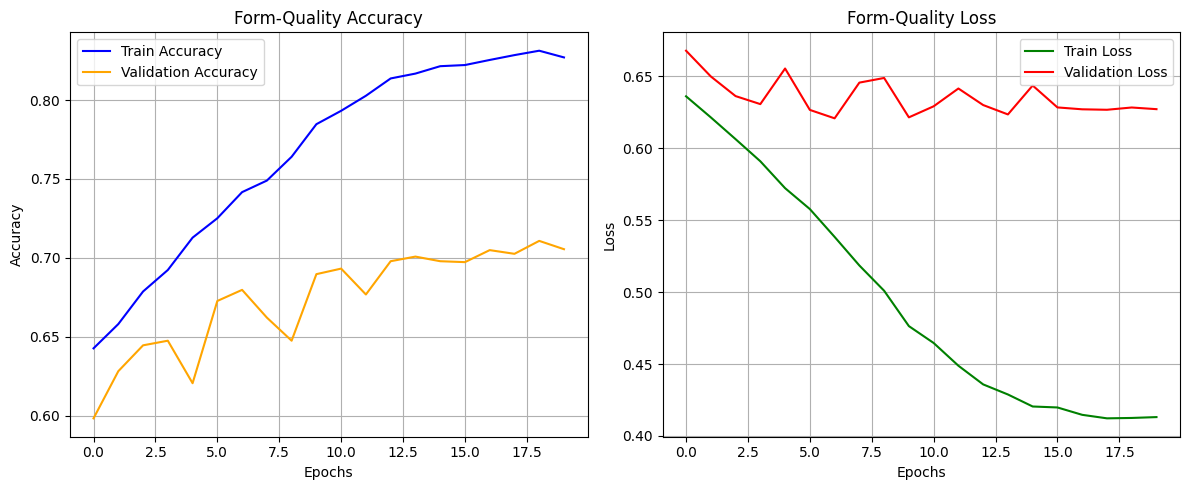

In [36]:
# Plot training vs validation curves for form-quality performance

import matplotlib.pyplot as plt

# Combine history objects if you trained in multiple phases (optional)
# e.g. history + history2; here assuming you used `history`
hist = history.history  # replace with `history2.history` if needed

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(hist["form_quality_accuracy"], label="Train Accuracy", color="blue")
plt.plot(hist["val_form_quality_accuracy"], label="Validation Accuracy", color="orange")
plt.title("Form-Quality Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(hist["form_quality_loss"], label="Train Loss", color="green")
plt.plot(hist["val_form_quality_loss"], label="Validation Loss", color="red")
plt.title("Form-Quality Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
